<a href="https://colab.research.google.com/github/aryannuka/data-science/blob/main/Arihanth_Nuka_Unit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Does the Position of a Basketball Player affect their Free Throw Percentage?

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import pandas as pd

## Setting up the Data

In this project, I want to determine the relationship between a basketball player's position and their Free Throws made. The dataset I'm using consists of basketball players in the NBA, and each of their major indentifying information like wage, age, team, etc.

In [24]:
#raw csv basketball data data
path = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'

In [4]:
#Position column to a categorical varliable
data = pd.read_csv(path,dtype={'Pos':'category'})

In [5]:
#full data table
data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


I created a violin plot for the Free throw data first to get an idea of the distribution.

<Axes: ylabel='FT'>

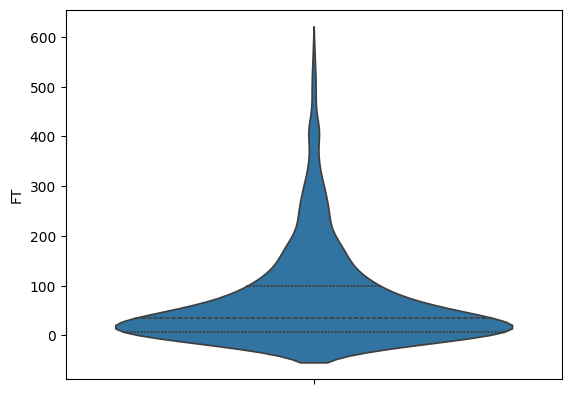

In [9]:
#data plot
sns.violinplot(data.FT,inner='quart')

## Creating a Predictive Model

In [10]:
data['Pos'] = pd.Categorical(data.Pos)
Pos_idx = data.Pos.cat.codes.values
Pos_codes = data.Pos.cat.categories
Pos_coords = {"Pos": Pos_codes}

I started by using the normal model to compare its match to the free throw accuracy to see how it would fit the data. This model's predictive mean was too far off the predictive mean, so I needed to use a model with a larger postive skew that matched my data.

In [20]:
with pm.Model(coords=Pos_coords) as Pos_h_model:
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    μ = pm.Normal('μ',  mu = μ_mu, sigma = μ_sd, dims = "Pos")
    σ = pm.HalfNormal('σ', sigma = 10, dims = "Pos")
    #normal likelihood
    y = pm.Normal('y',
                  mu = μ[Pos_idx],
                  sigma = σ[Pos_idx],
                  observed = data.FT)
    idata_Pos_h = pm.sample(target_accept = 0.98)

Output()

Output()

ERROR:pymc.stats.convergence:There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

<Axes: xlabel='y'>

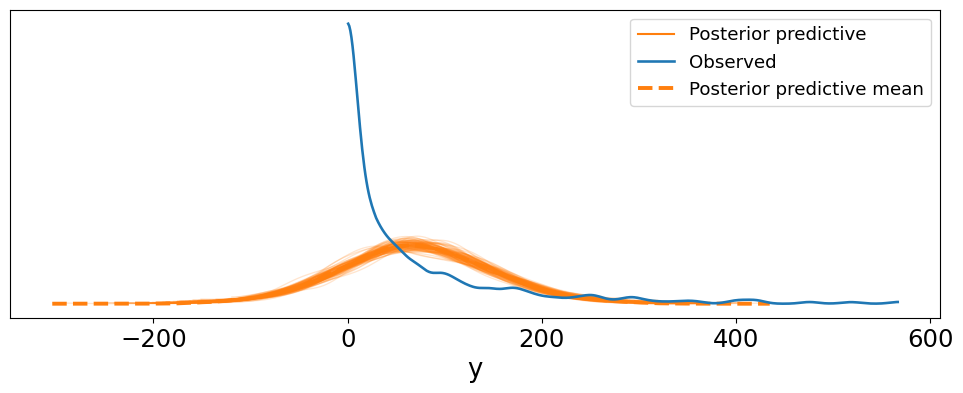

In [22]:
pm.sample_posterior_predictive(idata_Pos_h, model=Pos_h_model, extend_inferencedata=True)
az.plot_ppc(idata_Pos_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Here I use an exponential model because it matches the distribution of the observed skewed data. I noticed I required a very high lambda value to match, so with my Gamma hypepriors, I plugged in very extreme values. This posterior predictive mean fit the observed much better.

In [23]:
with pm.Model(coords = Pos_coords) as bsktbl_model:
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)
    λ = pm.Gamma('λ', alpha = a, beta = b)
    #exponential likelihood
    _ = pm.Exponential('Pos', lam = λ, observed = data.FT)
    idata_bsktbl = pm.sample(target_accept = 0.95)

Output()

Output()

Output()

<Axes: xlabel='Pos'>

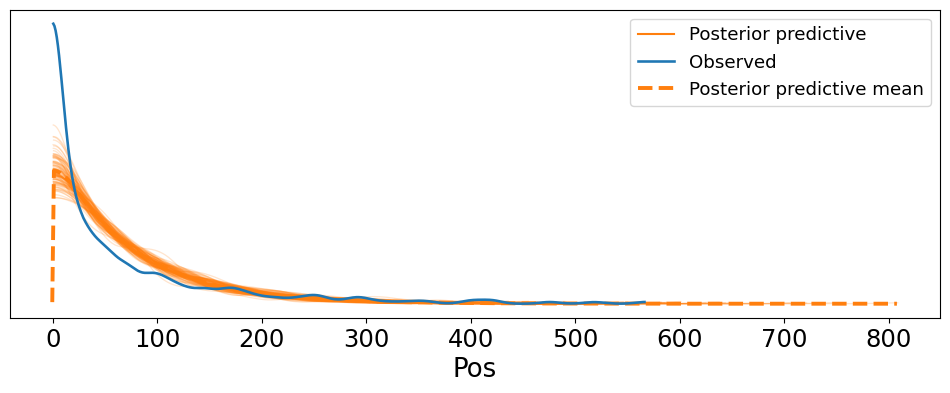

In [ ]:
pm.sample_posterior_predictive(idata_bsktbl, model=bsktbl_model, extend_inferencedata=True)
az.plot_ppc(idata_bsktbl, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

As this model matched my data, I can now use the hierarchal model to compare the free throws to the position.

In [ ]:
with pm.Model(coords = Pos_coords) as bsktbl_model:
   #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)
    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b, dims = "Pos")
    #exponential likelihood
    _ = pm.Exponential('Pos', lam = λ[Pos_idx], observed = data.FT)
    idata_bsktbl = pm.sample(target_accept = 0.95)

Output()

Output()

## Analyzing the Model

<xarray.Dataset> Size: 352B
Dimensions:  (Pos: 12)
Coordinates:
  * Pos      (Pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    a        float64 8B 1.0
    b        float64 8B 1.0
    λ        (Pos) float64 96B 1.005 0.9998 1.001 1.001 ... 1.001 1.001 0.9998

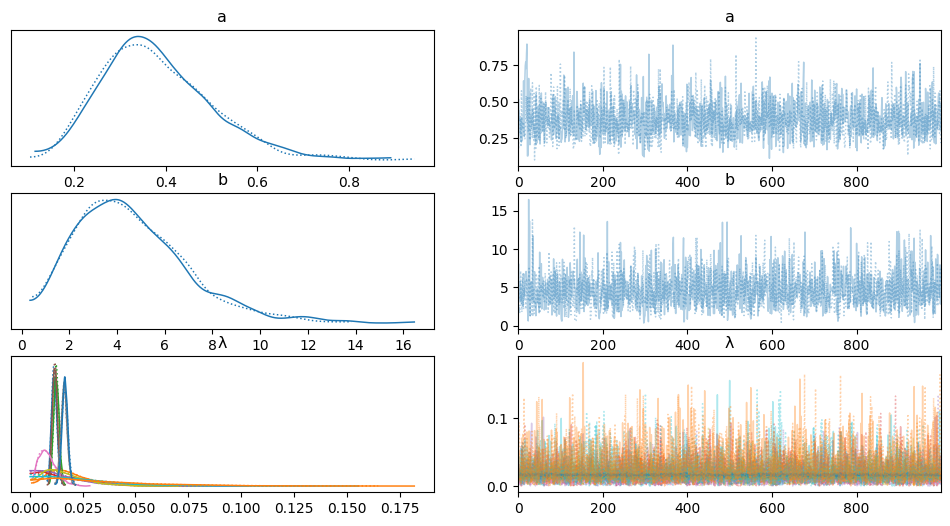

In [ ]:
az.plot_trace(idata_bsktbl)
az.rhat(idata_bsktbl)

array([<Axes: >], dtype=object)

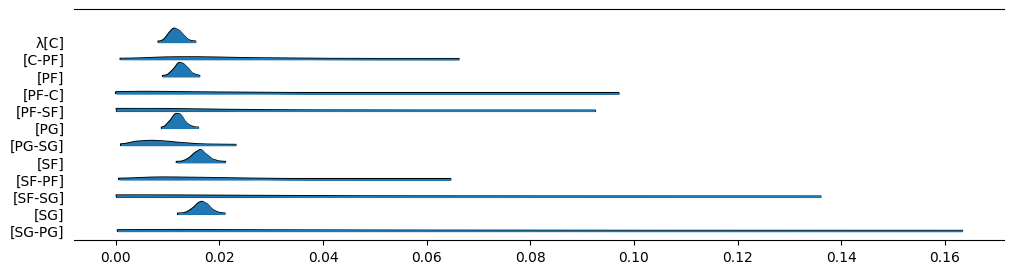

In [ ]:
az.plot_forest(idata_bsktbl, var_names=['λ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

Here I estimated the data for the center of the data cluster for the free throw accuracy to find the average for each position.

In [ ]:
print(f'(C): {(1/(0.012))}')
print(f'(C-PF): {(1/(0.019))}')
print(f'(PF): {(1/(0.013))}')
print(f'(PF-C): {(1/(0.019))}')
print(f'(PF-SF): {(1/(0.016))}')
print(f'(PG): {(1/(0.012))}')
print(f'(PG-SG): {(1/(0.008))}')
print(f'(SF): {(1/(0.016))}')
print(f'(SF-PF): {(1/(0.017))}')
print(f'(SF-SG): {(1/(0.025))}')
print(f'(SG): {(1/(0.017))}')
print(f'(SG-PG): {(1/(0.034))}')

(C): 83.33333333333333
(C-PF): 52.631578947368425
(PF): 76.92307692307692
(PF-C): 52.631578947368425
(PF-SF): 62.5
(PG): 83.33333333333333
(PG-SG): 125.0
(SF): 62.5
(SF-PF): 58.8235294117647
(SF-SG): 40.0
(SG): 58.8235294117647
(SG-PG): 29.41176470588235


In regards to my question, I can say that the position a basketball player plays does appear to relate to the free throws they make to some degree. The modeling process using the exponential model, revealed variations in free throw percentages based on position categories. However, the degree of this relationship differs across positions.
Some positions (e.g., centers, point guards, and powerr forwards) seem to do slightly better in their free throw percentages compared to guards. Because guards are the position that usually more with the ball, gets fouled frequently and has more experience shooting free throws throughout their careers, this does hint to lower amounts of true positional responsibility that may affect FT performance, but also opens up a wider range of free throw ability.

And it is a nuanced relationship where not all positions are equally strong in this regard. Specifically, some free throw distributions have overlap on positions, which indicates position only influences free throws to a certain degree before having little impact compared to factors such as height and skill or game strategy in individual games. This analysis could be further refined down to each stat category by adjusting for other variables such as player experience or free throw attempts.